<a href="https://colab.research.google.com/github/andrew-ryabchenko/DS-Unit-2-Linear-Models/blob/master/LS_DS_213_guided_project_notes_(Nicholas_Lecture).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    !pip install category_encoders==2.*

# I. Wrangle Data

## Import

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', parse_dates = ['created'], index_col = 'created')

## EDA

In [ ]:
def wrangle(df):
  # Make a copy of df
  df = df.copy()

  # Remove outliers
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
  return df

In [ ]:
df = wrangle(df)

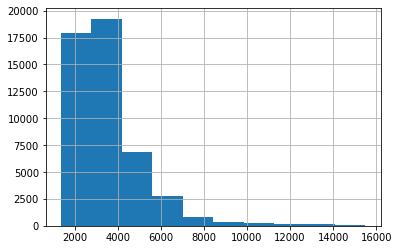

In [ ]:
df['price'].hist()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-nul

## **Problem:** High-cardinality categorical data

# II. Split Data

Split **target vector** from **feature matrix**.

In [ ]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

In [ ]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [ ]:
from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 1201.8811133682555


## IV. Build `LinearRegression` Model


In [ ]:
from category_encoders import OneHotEncoder

# Instanciate transformer

ohe = OneHotEncoder(use_cat_names=True)
# OneHotEncoder?
ohe.fit(X_train)
ohe.fit(X_test)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


OneHotEncoder(cols=['interest_level'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', return_df=True,
              use_cat_names=True, verbose=0)

In [ ]:
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)
XT_train.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31844 entries, 2016-04-17 03:26:41 to 2016-04-12 02:48:07
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bathrooms              31844 non-null  float64
 1   bedrooms               31844 non-null  int64  
 2   latitude               31844 non-null  float64
 3   longitude              31844 non-null  float64
 4   interest_level_medium  31844 non-null  int64  
 5   interest_level_low     31844 non-null  int64  
 6   interest_level_high    31844 non-null  int64  
 7   elevator               31844 non-null  int64  
 8   cats_allowed           31844 non-null  int64  
 9   hardwood_floors        31844 non-null  int64  
 10  dogs_allowed           31844 non-null  int64  
 11  doorman                31844 non-null  int64  
 12  dishwasher             31844 non-null  int64  
 13  no_fee                 31844 non-null  int64  
 14  laundry_in_building

In [ ]:
from sklearn.linear_model import LinearRegression


model_lr = LinearRegression()

model_lr.fit(XT_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# V. Check Metrics

# Back to IV. Build `Ridge` Regression Model

In [ ]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(k=7,)

skb.fit(XT_train, y_train)
skb.fit(XT_test, y_test)

XTT_train = skb.transform(XT_train)
XTT_test = skb.transform(XT_train)

In [ ]:
pd.DataFrame(XTT_test)

,0,1,2,3,4,5,6
0,1.0,1.0,-74.0018,0.0,0.0,0.0,0.0
1,1.0,1.0,-73.9677,0.0,0.0,0.0,0.0
2,1.0,4.0,-73.9493,0.0,0.0,0.0,0.0
3,2.0,4.0,-74.0028,0.0,0.0,0.0,0.0
4,1.0,2.0,-73.9660,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
31839,1.0,1.0,-73.9869,1.0,0.0,0.0,0.0
31840,1.0,1.0,-74.0163,1.0,1.0,0.0,0.0
31841,1.0,1.0,-73.9900,1.0,0.0,0.0,0.0
31842,1.0,0.0,-74.0101,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

In [ ]:
model_r = Ridge(alpha = 1.0)
model_r.fit(XTT_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)